# AI Data Exploration

This notebook contains the exploration and tinkering phase type stuff for the various weather model data
Hopefully we get some pretty plots and maybe look at some different attributes and stuff

In [60]:
# Data
import numpy as np
import netCDF4 as nf
import pandas as pd
import xarray as xr
import datetime
# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
# General
import scipy
import openpyxl
import tqdm

import imageio
from IPython.display import Image
# Using cyclone tracking to create some pretty plots
from cyclone_tracking_v1 import *

## Constants

In [2]:
crs_us = ccrs.LambertConformal(central_longitude=260.0)
crs_global_atlantic = ccrs.PlateCarree(central_longitude=0.0)
root_path = '/mnt/d/VS-workspace/AI2ES/AI_NWP/'
data_root_path = '%smodel_data/noaa-oar-mlwp-data/'%(root_path)

# This is for grabbing the same date/time for the comparing the model datasets
year = '2021'
day = '1022' 
init = '00' # Either 00 or 12 

# In Pa
vmin = 94000
vmax = 104000

In [3]:
def plot_subset_background(ax, lonmin, lonmax, latmin, latmax):
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

In [4]:
def plot_background_no_lims(ax):
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

In [5]:
def find_storm_domain(dataset):
    bounds = [None] * 4
    bounds[0] = dataset['longitude'].min()
    bounds[1] = dataset['longitude'].max()
    bounds[2] = dataset['latitude'].min()
    bounds[3] = dataset['latitude'].max()
    return bounds

## File IO

In [6]:
pangu_weather = xr.open_dataset('PANG_v100_GFS_%s%s%s_f000_f240_06.nc'%(year, day, init))
pangu_weather

<xarray.Dataset>
Dimensions:    (time: 41, longitude: 1440, latitude: 721, level: 13)
Coordinates:
  * time       (time) datetime64[ns] 2021-10-22 ... 2021-11-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1000 925 850 700 600 500 400 300 250 200 150 100 50
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:           CF-1.8
    version:               1_2023-10-14
    model_name:            Pangu-Weather
    model_version:         v1
    initialization_model:  GFS
    initialization_time:   2021-10-22T00:00:00
    first_forecast_hour:   6
    last_forecast_hour:    240
    forecast_hour_step:    6
    creation_time:         2023-11-19T07:54:32

## Exploration

Text(0.5, 1.0, 'Pangu-Weather MSLP (Pa)')

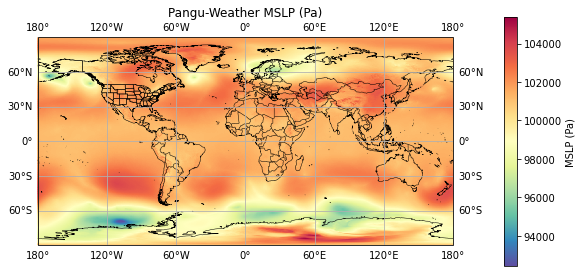

In [7]:
# Here lets just throw a plot together
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8,7), constrained_layout=True,
                            subplot_kw={'projection': crs_global_atlantic})
domain = find_storm_domain(pangu_weather)
#plot_subset_background(axes[0], domain[0], domain[1], domain[2], domain[3])
#plot_subset_background(axes[1], domain[0], domain[1], domain[2], domain[3])
plot_background_no_lims(axes)

cf1 = pangu_weather['msl'].isel(time=0).plot(ax=axes, x='longitude', y='latitude',
                    cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder = 0, add_colorbar = False)

fig.colorbar(cf1, ax = axes, shrink = 0.5).set_label(label = 'MSLP (Pa)')
axes.set_title("Pangu-Weather MSLP (Pa)")
#plt.suptitle("Pangu-Weather (top) versus FourCastNetV2 (bottom)")

[99772.4 99732.  99696.4 ... 99892.2 99853.6 99812.8]


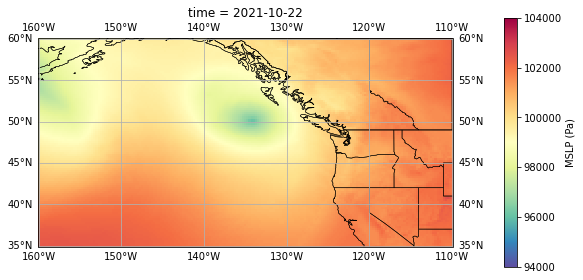

In [33]:
crs_pnw = ccrs.LambertConformal(central_longitude=240.0)

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,7), constrained_layout=True,
#                            subplot_kw={'projection': crs_pnw})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,7), constrained_layout=True,
                            subplot_kw={'projection': crs_global_atlantic})

domain=[200,250,35,60]
#plot_subset_background(ax,domain[0],domain[1],domain[2],domain[3])
plot_background_no_lims(ax)
#plot_background_no_lims(ax)
if (domain[0] < (pangu_weather['longitude'].min().values) or 
                (domain[1] > pangu_weather['longitude'].max().values) or
                (domain[2] < pangu_weather['latitude'].min().values) or 
                (domain[3] > pangu_weather['latitude'].max().values)):
    print("Domain values are outside the range of the dataset.")

pnw_msl = pangu_weather['msl'].isel(time=0).sel(longitude=slice(domain[0],domain[1]),latitude=slice(domain[3],domain[2])).to_numpy()

#print(pnw_msl)
#print(pangu_weather['msl'].isel(time=0).sel(longitude=slice(domain[0],domain[1])))
print(pangu_weather['msl'].isel(time=0).sel(latitude=domain[3]).to_numpy())

#cf1 = ax.pcolormesh(pnw_msl, cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder = 0)
#cf1 = ax.pcolormesh(pangu_weather['msl'].isel(time=0).sel(longitude=slice(domain[0],domain[1])).to_numpy(), cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder = 0)

#fig.colorbar(cf1, ax = ax, shrink = 0.5).set_label(label = 'MSLP (Pa)')

cf1 = pangu_weather['msl'].isel(time=0).sel(longitude=slice(domain[0],domain[1]),latitude=slice(domain[3],domain[2])).plot(ax=ax, x='longitude', y='latitude',
                    cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder = 0, add_colorbar = False, vmin=vmin, vmax=vmax)
fig.colorbar(cf1, ax = ax, shrink = 0.5).set_label(label = 'MSLP (Pa)')

<xarray.DataArray 'msl' (latitude: 101, longitude: 201)>
array([[ 98423.8,  98502.6,  98608.6, ..., 102054.6, 102085.4, 102117. ],
       [ 98416.8,  98505.2,  98579.2, ..., 102057.6, 102088.2, 102118.8],
       [ 98396.4,  98439.2,  98500.4, ..., 102061.6, 102095. , 102126. ],
       ...,
       [102411.2, 102423.6, 102427.2, ..., 101820.4, 101843.8, 101856.8],
       [102429.2, 102437. , 102442.2, ..., 101789.4, 101782.8, 101780.8],
       [102450.8, 102448.8, 102453.2, ..., 101758.8, 101746.4, 101749.4]],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2021-10-22
  * longitude  (longitude) float32 200.0 200.2 200.5 200.8 ... 249.5 249.8 250.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 35.5 35.25 35.0
Attributes:
    long_name:  Pressure reduced to MSL
    units:      Pa
(40, 103)
<xarray.DataArray 'msl' (latitude: 101, longitude: 201)>
array([[ 97923.336,  97997.62 ,  98083.3  , ..., 102018.984, 102057.23 ,
        102082.695],
       [ 97865.27 ,  9

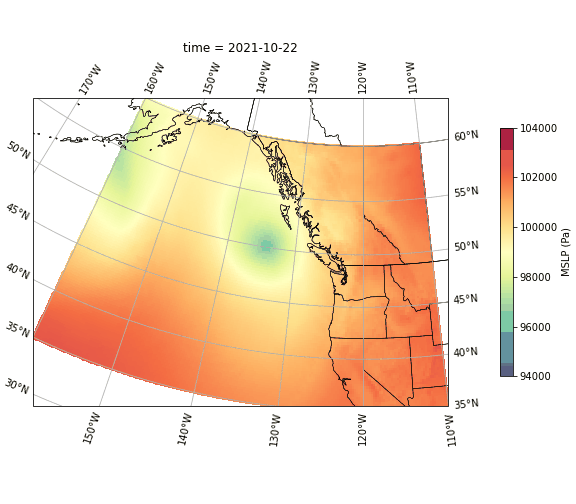

In [42]:
cyclone_progress = []
frames = []
# Subsetting the domain
for time in range(0,20):
    # Here we want to track the minimum pressure along with the lat/lon
    '''minp = np.nanmin(pangu_weather['msl'].isel(time=time).sel(longitude=slice(domain[0],domain[1]),latitude=slice(domain[3],domain[2])).to_numpy())
    min_indices = np.where(
    pangu_weather['msl']
    .isel(time=time)
    .sel(longitude=slice(domain[0], domain[1]), latitude=slice(domain[3], domain[2]))
    .to_numpy() == minp)
    print(min_indices)
    cyclone_dict = {'lon' : pangu_weather['longitude'].values[min_indices[1][0]],
                    'lat' : pangu_weather['latitude'].values[min_indices[0][0]],
                    'msl' : minp}
    cyclone_progress.append(cyclone_dict)'''
    msl_subset = pangu_weather['msl'].isel(time=time).sel(longitude=slice(domain[0], domain[1]), latitude=slice(domain[3], domain[2]))
    #print(msl_subset)

    # Find the minimum pressure value and its indices within the subset
    minp = np.nanmin(msl_subset)
    min_indices = np.unravel_index(np.nanargmin(msl_subset), msl_subset.shape)
    #print(min_indices)
    
    # Calculate the latitude and longitude values based on the domain
    lon_values = msl_subset['longitude'].values[min_indices[1]]
    lat_values = msl_subset['latitude'].values[min_indices[0]]
    #lon_values = pangu_weather['longitude'].isel(longitude=min_indices[0]).values
    #lat_values = pangu_weather['latitude'].isel(latitude=min_indices[1]).values
    
    # Create a dictionary to store the cyclone information
    cyclone_dict = {'lon': lon_values, 'lat': lat_values, 'msl': minp}
    
    # Append the cyclone dictionary to the cyclone progress list
    cyclone_progress.append(cyclone_dict)

    # Now working on making the plots
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,7), constrained_layout=True,
                            subplot_kw={'projection': crs_pnw}, facecolor='w')

    plot_subset_background(ax,domain[0],domain[1],domain[2],domain[3])
    
    cf1 = pangu_weather['msl'].isel(time=time).sel(longitude=slice(domain[0],domain[1]),latitude=slice(domain[3],domain[2])).plot(ax=ax, x='longitude', y='latitude',
                    cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder = 0, add_colorbar = False, vmin=vmin, vmax=vmax)
    fig.colorbar(cf1, ax = ax, shrink = 0.5).set_label(label = 'MSLP (Pa)')
    fig.savefig('gifs/frames/%s_%s_%s_PANG_time_%s.png'%(year, day, init, time))
    picture = imageio.imread('gifs/frames/%s_%s_%s_PANG_time_%s.png'%(year, day, init, time))
    frames.append(picture)
    plt.close()
#print(len(frames))
imageio.mimsave('gifs/%s_%s_%s_PANG.gif'%(year, day, init), frames, duration = 0.5)
Image('gifs/%s_%s_%s_PANG.gif'%(year, day, init))

[{'lon': 25.75, 'lat': 80.0, 'msl': 96052.0}, {'lon': 0.0, 'lat': 86.25, 'msl': 96601.77}, {'lon': 0.0, 'lat': 86.5, 'msl': 96191.09}, {'lon': 1.0, 'lat': 85.25, 'msl': 95879.62}, {'lon': 4.75, 'lat': 85.0, 'msl': 96378.19}, {'lon': 7.25, 'lat': 84.75, 'msl': 96572.336}, {'lon': 9.25, 'lat': 84.75, 'msl': 96609.6}, {'lon': 11.25, 'lat': 84.75, 'msl': 96557.62}, {'lon': 12.75, 'lat': 84.75, 'msl': 96744.266}, {'lon': 25.75, 'lat': 73.75, 'msl': 96947.734}, {'lon': 28.0, 'lat': 75.75, 'msl': 95296.195}, {'lon': 29.0, 'lat': 76.0, 'msl': 94631.086}, {'lon': 30.0, 'lat': 77.0, 'msl': 94881.41}, {'lon': 30.75, 'lat': 77.75, 'msl': 95438.31}, {'lon': 30.75, 'lat': 78.0, 'msl': 96112.984}, {'lon': 32.5, 'lat': 78.5, 'msl': 97023.94}, {'lon': 13.5, 'lat': 88.75, 'msl': 97862.19}, {'lon': 14.0, 'lat': 81.25, 'msl': 97792.58}, {'lon': 18.75, 'lat': 81.75, 'msl': 97680.95}, {'lon': 22.5, 'lat': 82.5, 'msl': 97753.086}]


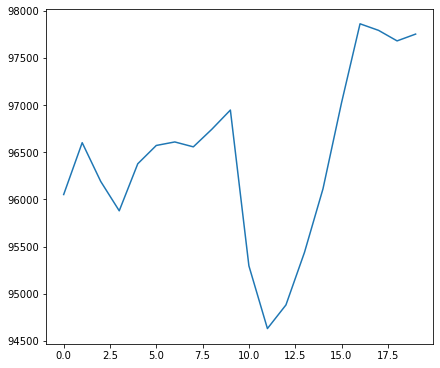

In [34]:
fig, ax = plt.subplots(1,1,figsize = (6,5), constrained_layout=True, facecolor = 'w')

mins = [time['msl'] for time in cyclone_progress]

ax.plot(range(0,len(mins)), mins)
#print(cyclone_progress)

In [11]:
# We will need to adjust this rate to adjust for latitude
def bomb_cyclone_check(cyclone_list):
    bomb_cyclone_in = []
    for t, c_dict in enumerate(cyclone_list):
        count = 1
        while(t-count >= 0 and count <= 4):
            #print("t = %s\t t-%s = %s"%(str(t),str(count), str(t-count)))

            # Represents the percentage of the bomb-cyclone intensification rate when using 1mbhr^-1
            int_r8 = ((cyclone_list[t-count]['msl'] - c_dict['msl'])/(6*count)) / 100
            #print(int_r8)
            if int_r8 > 1: 
                print("Bomb cyclone at: " +str(t))
                bomb_dict = {'t_curr' : t,
                             't_begin' : t-count,
                             'msl_curr' : c_dict['msl'],
                             'msl_begin' : cyclone_list[t]['msl'],
                             'rate' : int_r8}
                bomb_cyclone_in.append(bomb_dict)
            count += 1

    return bomb_cyclone_in

bomb_list = bomb_cyclone_check(cyclone_progress)
for i,b in enumerate(bomb_list):
    print(b , '\n')

Bomb cyclone at: 10
Bomb cyclone at: 10
Bomb cyclone at: 11
Bomb cyclone at: 11
Bomb cyclone at: 11
Bomb cyclone at: 12
{'t_curr': 10, 't_begin': 9, 'msl_curr': 95296.195, 'msl_begin': 95296.195, 'rate': 2.752565104166667} 

{'t_curr': 10, 't_begin': 8, 'msl_curr': 95296.195, 'msl_begin': 95296.195, 'rate': 1.2067252604166667} 

{'t_curr': 11, 't_begin': 10, 'msl_curr': 94631.086, 'msl_begin': 94631.086, 'rate': 1.108515625} 

{'t_curr': 11, 't_begin': 9, 'msl_curr': 94631.086, 'msl_begin': 94631.086, 'rate': 1.9305403645833334} 

{'t_curr': 11, 't_begin': 8, 'msl_curr': 94631.086, 'msl_begin': 94631.086, 'rate': 1.1739887152777777} 

{'t_curr': 12, 't_begin': 9, 'msl_curr': 94881.41, 'msl_begin': 94881.41, 'rate': 1.1479600694444445} 



[225.75, 200.0, 200.0, 201.0, 204.75, 207.25, 209.25, 211.25, 212.75, 225.75, 228.0, 229.0, 230.0, 230.75, 230.75, 232.5, 213.5, 214.0, 218.75, 222.5]
[50.0, 56.25, 56.5, 55.25, 55.0, 54.75, 54.75, 54.75, 54.75, 43.75, 45.75, 46.0, 47.0, 47.75, 48.0, 48.5, 58.75, 51.25, 51.75, 52.5]


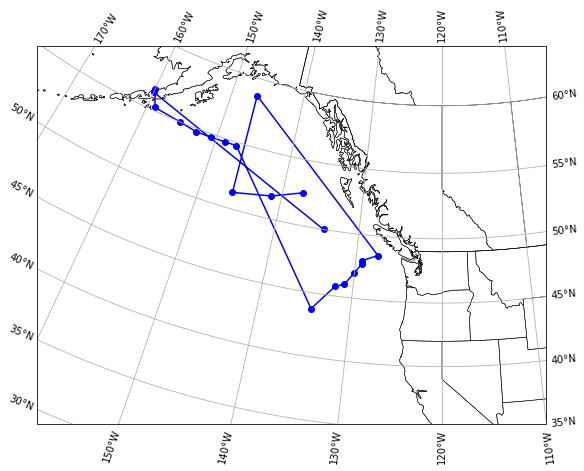

In [47]:
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7), constrained_layout=True, subplot_kw={'projection': crs_pnw}, facecolor='w')
plot_subset_background(ax,domain[0],domain[1],domain[2],domain[3])


lons = []
lats = []
msls = []

for cyc in cyclone_progress:
    lons.append(cyc['lon'])
    lats.append(cyc['lat'])
    msls.append(str(cyc['msl']))

print(lons)
print(lats)
# Plot the cyclone track using PlateCarree CRS
ax.plot(lons, lats, color='blue', marker='o',transform=ccrs.PlateCarree())


Text(0.5, 1.0, 'Cyclone central low pressure over time classified by Intensification rate')

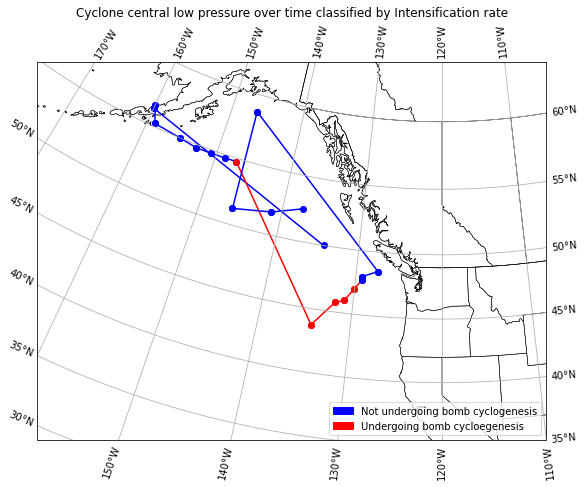

In [55]:
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7), constrained_layout=True, subplot_kw={'projection': crs_pnw}, facecolor='w')
plot_subset_background(ax, domain[0], domain[1], domain[2], domain[3])

lons = []
lats = []
msls = []

# Initialize color list
colors = []

for cyc in cyclone_progress:
    lons.append(cyc['lon'])
    lats.append(cyc['lat'])
    msls.append(str(cyc['msl']))
    colors.append('blue')  # Default color is blue

# Identify the time intervals when the cyclone is undergoing bomb cyclone intensification
for bomb_cyclone in bomb_list:
    start_t = bomb_cyclone['t_begin']
    end_t = bomb_cyclone['t_curr']
    # Set color to red for the time interval when the cyclone is undergoing bomb cyclone intensification
    colors[start_t:end_t+1] = ['red'] * (end_t - start_t + 1)

for i in range(len(lons) - 1):
    ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], color=colors[i], marker='o', transform=ccrs.PlateCarree())

blue_patch = mpatches.Patch(color='blue', label='Not undergoing bomb cyclogenesis')
red_patch = mpatches.Patch(color='red', label='Undergoing bomb cycloegenesis')
ax.legend(handles=[blue_patch, red_patch], loc='lower right')

ax.set_title("Cyclone central low pressure over time classified by Intensification rate")

In [71]:
print('jello')

jello


## Code that I am currently ditching

Not because I don't think it would be cool but just because for the amount of time I would need to make it work, it probably won't be worthwhile

/var/folders/6l/pkhs4d6n64d7tsbyjv6l8mbh0000gn/T/ipykernel_68088/3483841761.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points = np.array([msl_subset['longitude'].values, msl_subset['latitude'].values]).T.reshape(-1, 1, 2)


AttributeError: 'numpy.datetime64' object has no attribute 'fromtimestamp'

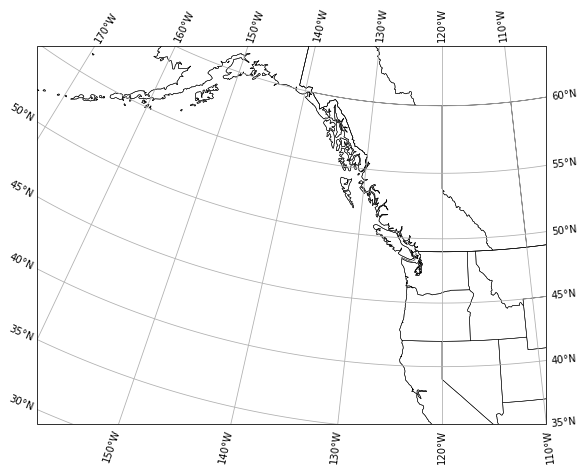

In [70]:
'''def datetime_to_float(d):
      return d.fromtimestamp
def float_to_datetime(f):
  return pd.to_datetime(f)
def float_to_datetime_array(arr):
  arrf = [None] * len(arr)
  for i in range(0,len(arr)):
    arrf[i] = pd.to_datetime(arr[i])
  return arrf

# Making the colorbar follow the cyclone path over time
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7), constrained_layout=True, subplot_kw={'projection': crs_pnw}, facecolor='w')
plot_subset_background(ax,domain[0],domain[1],domain[2],domain[3])

points = np.array([msl_subset['longitude'].values, msl_subset['latitude'].values]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(pangu_weather['time'].isel(time=0).values, pangu_weather['time'].isel(time=20).values)
lc = LineCollection(segments, cmap='viridis', norm=norm, transform = ccrs.PlateCarree())
# Set the values used for colormapping
times = [datetime_to_float(t) for t in pangu_weather['time'].isel(time=slice(0,20)).values]
lc.set_array(times)
lc.set_linewidth(5)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax, label = 'Time')'''